In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics

In [4]:
adata_1=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section2_add_tumor_region.h5ad')
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'spatial'

In [5]:
adata_2=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section1_add_tumor_region.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'spatial'
    obsm: 'spatial'

In [6]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [7]:
Cal_Spatial_Net(adata_1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 41691 edges, 3987 cells.
10.45673438675696 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 39636 edges, 3798 cells.
10.436018957345972 neighbors per cell on average.


In [8]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 21.50


In [10]:
adata_1.obsm['SLAT'] = embd2.detach().cpu().numpy()
adata_2.obsm['SLAT'] = embd3.detach().cpu().numpy()
adata_com_2 = sc.concat([adata_1,adata_2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'SLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


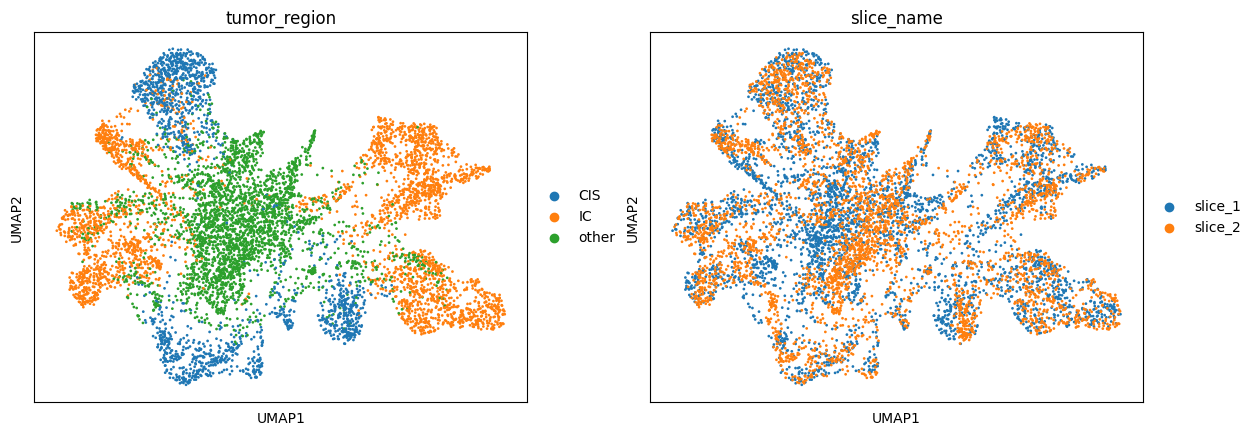

In [11]:
sc.pl.umap(adata_com_2, color= ['tumor_region','slice_name'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


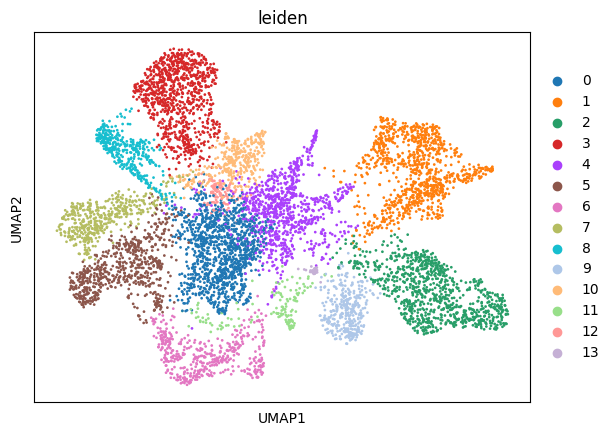

14

In [15]:
sc.pp.neighbors(adata_com_2, use_rep= 'SLAT', random_state= 666)
sc.tl.leiden(adata_com_2, resolution = 0.57)

sc.pl.umap(adata_com_2, color=['leiden'])
len(adata_com_2.obs.leiden.cat.categories)

In [17]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

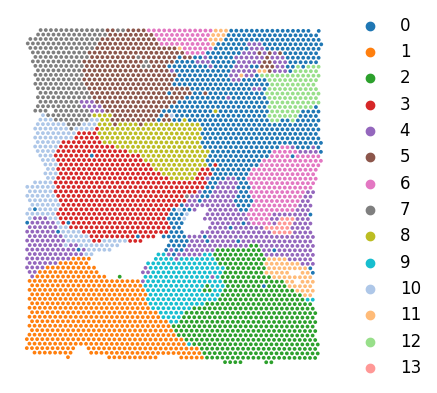

In [18]:
sc.pl.spatial(adata_com_2[0:3987,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

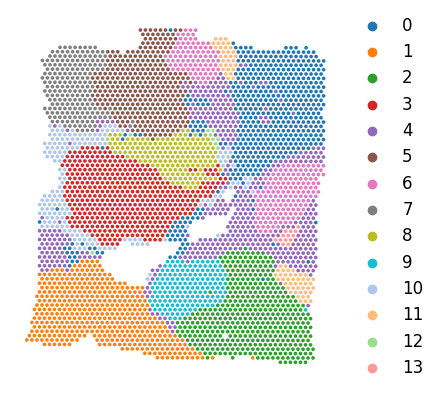

In [19]:
sc.pl.spatial(adata_com_2[3987:7785,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [20]:
adata_com_2

AnnData object with n_obs × n_vars = 7785 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'slice_name', 'leiden'
    uns: 'neighbors', 'umap', 'tumor_region_colors', 'slice_name_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'SLAT', 'X_umap'
    obsp: 'distances', 'connectivities'

In [21]:
# adata_com_2.write('D:\ppppaper\data\Result\BAS2_BAS1_SLAT.h5ad')